### Importing/Installing Libraries


In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# reminder that if you are installing libraries in a Google Colab instance you will be prompted to restart your kernal

try:
    import geemap, ee
    import seaborn as sns
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print("package not found, installing w/ pip in Google Colab...")
        !pip install geemap seaborn matplotlib
    else:
        print("package not found, installing w/ conda...")
        !conda install mamba -c conda-forge -y
        !mamba install geemap -c conda-forge -y
        !conda install seaborn matplotlib -y
    import geemap, ee
    import seaborn as sns
    import matplotlib.pyplot as plt

In [3]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=BqMKKnOj-XfrnZMEi3DOt2u6OiBOlDiHAkfwNPJbbJs&tc=AW_n--jWrqxbu33JFv-fHRjExxlcbzAW2ZhywTA4nRE&cc=Skeu9FyiKumkQY1Kl8FNCGFPv8VdwPm-shoHY-or6AE

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXnNOWNbQe-ousYveS33yIAbWtCH2Ys8cNsw7ck1hu2ZOErQq3eyD48

Successfully saved authorization token.


In [4]:
from tqdm import tqdm
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from matplotlib import gridspec
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import geocoder
import datetime
import geemap.colormaps as cm

In [5]:

def get_coords(loc):
    g = geocoder.bing(loc, key='Ag-hhlLXX66GFF0QB3A84aPX16lgpoz-nGdT28B6IfGf_skCcDZ8XqG6qefUQ2-1')
    lat, lon = g.json['lat'], g.json['lng']

    return lat, lon

def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [14]:
def map_viewer(lat, lon, loc, buffer, start_date, end_date, zoom):
    poi = ee.Geometry.Point(lon, lat).buffer(buffer)
    viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(start_date, end_date)
    viirs_image = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(start_date, end_date).select('avg_rad').median()

    def poi_mean(img):
        mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi, scale=30).get('avg_rad')
        return img.set('date', img.date().format()).set('mean',mean)

    poi_reduced_imgs = viirs.map(poi_mean)
    viirs_clipped = viirs_image.clip(poi)

    viz_params = {'min':0,
             'max':5,
             'palette': cm.palettes.magma}

    Map = geemap.Map()
    Map.centerObject(poi, zoom=zoom)
    Map.add_basemap("HYBRID")
    Map.addLayer(poi, {}, str(loc), opacity = 0.3)

    Map.addLayer(poi, {}, str(loc) + 'POI')
    Map.addLayer(viirs_clipped, viz_params, str(loc) + 'NTL-clipped',  opacity=0.10)
    Map.addLayer(viirs_image, viz_params, 'VIIRS DNB',  opacity=0.50)
    Map.add_colorbar(viz_params, label="NTL radiance, $nW ·cm^{−2}·sr^{−1}$", layer_name = "colorbar")
    Map.addLayerControl()
    return Map

In [8]:
def time_series_(lat, lon, buffer):
    def poi_mean(img):
        mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi, scale=30).get('DNB_BRDF_Corrected_NTL')
        return img.set('date', img.date().format()).set('mean',mean)

    poi = ee.Geometry.Point(lat, lon).buffer(buffer)
    black_marble = ee.ImageCollection('NOAA/VIIRS/001/VNP46A2').filterDate(start_date, end_date).select('DNB_BRDF_Corrected_NTL')
    poi_reduced_imgs = black_marble.map(poi_mean)
    nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date', 'mean']).values().get(0)
    data = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])
    data['date'] = pd.to_datetime(data['date'])
    data = data.set_index('date')
    return data

In [9]:
lat, lon = get_coords('Marawi City')
start_date, end_date = "2017-01-01", "2017-12-31"
time_series_(lon, lat, buffer = 500)

,mean
date,
2017-01-03,0.677898
2017-01-20,0.600000
2017-01-21,0.200000
2017-01-22,0.497062
2017-01-25,0.371768
...,...
2017-12-24,0.524641
2017-12-25,0.550272
2017-12-26,0.858592


In [41]:
def Black_Marble_STL(lat, lon, loc, buffer, start_date, end_date, period):

    def time_series_(lat, lon, buffer):
        def poi_mean(img):
            mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi, scale=30).get('DNB_BRDF_Corrected_NTL')
            return img.set('date', img.date().format()).set('mean',mean)

        poi = ee.Geometry.Point(lat, lon).buffer(buffer)
        black_marble = ee.ImageCollection('NOAA/VIIRS/001/VNP46A2').filterDate(start_date, end_date).select('DNB_BRDF_Corrected_NTL')
        poi_reduced_imgs = black_marble.map(poi_mean)
        nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date', 'mean']).values().get(0)
        data = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])
        data['date'] = pd.to_datetime(data['date'])
        data = data.set_index('date')
        return data

    black_marble_data = time_series_(lon, lat, buffer)
    y = moving_average(black_marble_data['mean'].tolist(), n = 4)

    decomposition = sm.tsa.seasonal_decompose(y, model='additive', period = period)
    decomposition_2 = sm.tsa.seasonal_decompose(y, model='additive', period = period*2)


    fig, ax = plt.subplots(nrows=4,ncols=1, sharex='col',
                          gridspec_kw={'height_ratios':[2, 1,0.6,0.6]},
                          figsize=(10,8))

    date = black_marble_data.index[3:]



    ax[0].plot(date, decomposition.trend, 'r', alpha = 0.3, lw = 3)
    ax[0].plot(date, decomposition.seasonal, color = 'orange', alpha = 0.3, lw = 1)
    ax[0].plot(date, y-0.1, 'k', lw = 2, drawstyle = 'steps-mid')
    ax[0].plot(date, y, 'b.-', lw = 2, drawstyle = 'steps-mid', label = str(loc))

    ax[0].bar(date, decomposition.resid, width = 1,
            color = plt.cm.Spectral(decomposition.resid), alpha = 0.5)
    ax[0].set_ylabel('NTL Radiance, $nW ·cm^{−2}·sr^{−1}$')

    ax[1].plot(date, decomposition.trend-0.02, 'k', lw = 2)
    ax[1].plot(date, decomposition.trend, 'r', label = 'trend', lw = 3)


    ax[2].plot(date, decomposition.seasonal, color = 'orange',  label = 'seasonality')

    residual = decomposition.resid
    ax[3].bar(date, residual, width = 1.5, label = 'residual')
    ax[3].bar(date, residual, width = 1.5,
            color = plt.cm.Spectral(residual))

    for ax in ax:
      ax.legend(loc = 1)
      ax.axvline(datetime.date(2021, 12, 16), color = 'r', lw = 5, alpha = 0.2) #For COVID lockdown

      # ax.axvline(datetime.date(2017, 5, 18), color = 'g', lw = 10, alpha = 0.2) #For Marawi Seige
      # ax.axvline(datetime.date(2020, 3, 10), color = 'g', lw = 10, alpha = 0.2) #For COVID lockdown

      ax.grid(alpha = 0.5)

    dtFmt = mdates.DateFormatter('%d-%b-%Y') # define the formatting
    plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
    plt.tight_layout()
    plt.show()

In [ ]:
loc = 'Marawi City'
lat, lon = get_coords(loc)
map_viewer(lat - 0.01, lon - 0.01, loc, 5000, "2017-01-01", "2018-02-01", zoom = 13)

Map(center=[8.011204359442102, 124.28657759364822], controls=(WidgetControl(options=['position', 'transparent_…

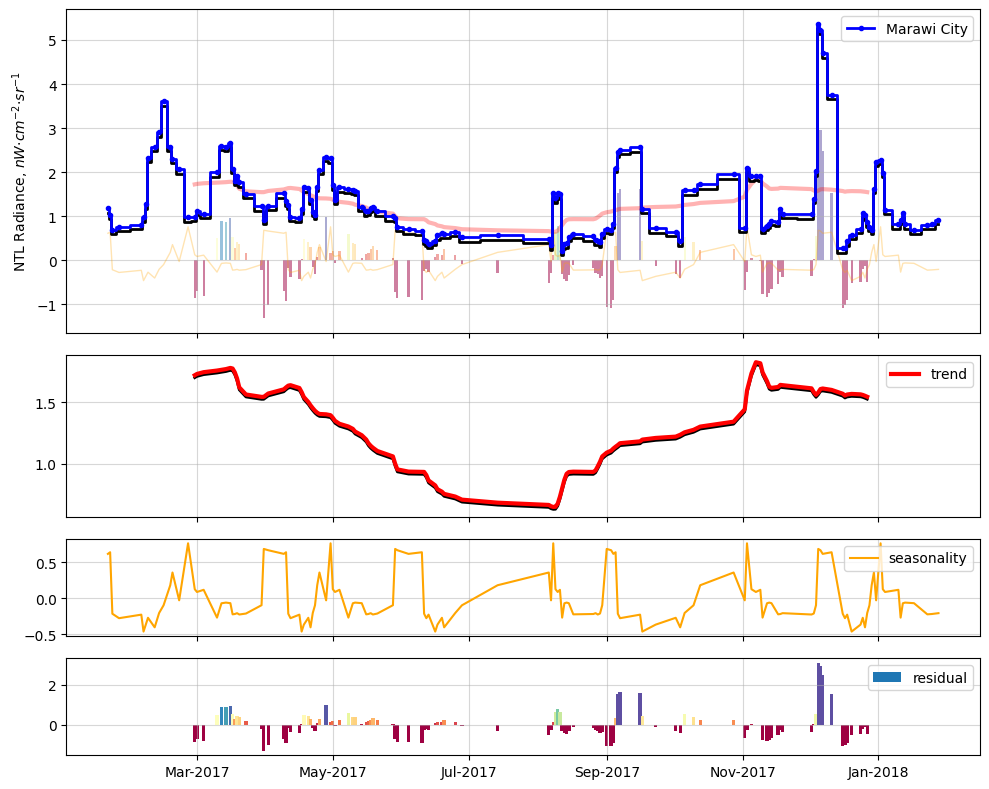

In [ ]:
Black_Marble_STL(lat-0.01, lon-0.01, loc, 5000, "2017-01-01", "2018-02-01", period = 30)

In [21]:
loc = 'General Luna, Siargao Island'
lat, lon = get_coords(loc)
delta = 0.09
map_viewer(lat-delta, lon+delta, loc, 5000, "2021-12-01", "2022-02-28", zoom = 10)

Map(center=[9.78286698944049, 126.14410018434602], controls=(WidgetControl(options=['position', 'transparent_b…

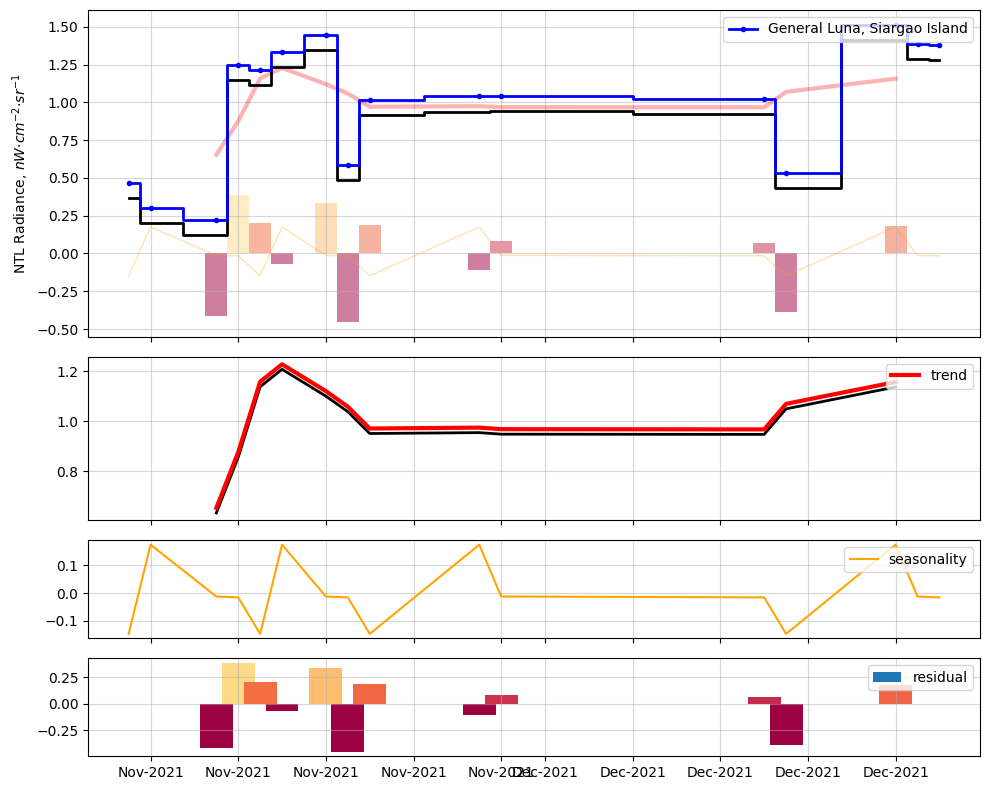

In [29]:
Black_Marble_STL(lat-delta, lon+delta, loc, 5000, "2021-11-01", "2022-1-01", period = 4)

In [52]:
loc = 'Cebu City'
lat, lon = get_coords(loc)
delta = 0.08
map_viewer(lat-delta, lon+delta, loc, 15000, "2021-12-01", "2022-02-28", zoom = 11)

Map(center=[10.299311688278372, 123.93997052372625], controls=(WidgetControl(options=['position', 'transparent…

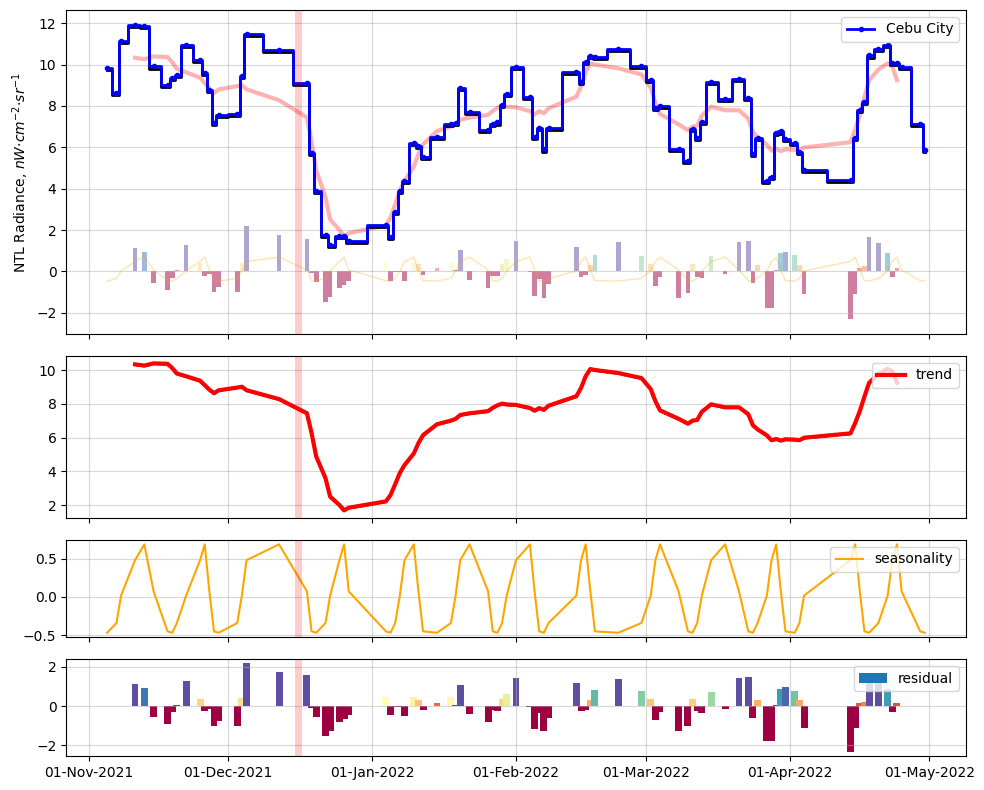

In [42]:
Black_Marble_STL(lat-delta, lon+delta, loc, 15000, "2021-11-01", "2022-5-01", period = 7)

In [50]:
loc = 'Tagbilaran, Bohol'
lat, lon = get_coords(loc)
delta = 0
map_viewer(lat-delta, lon+delta, loc, 5000, "2021-12-01", "2022-02-28", zoom = 12)

Map(center=[9.665698409447007, 123.87113204429767], controls=(WidgetControl(options=['position', 'transparent_…

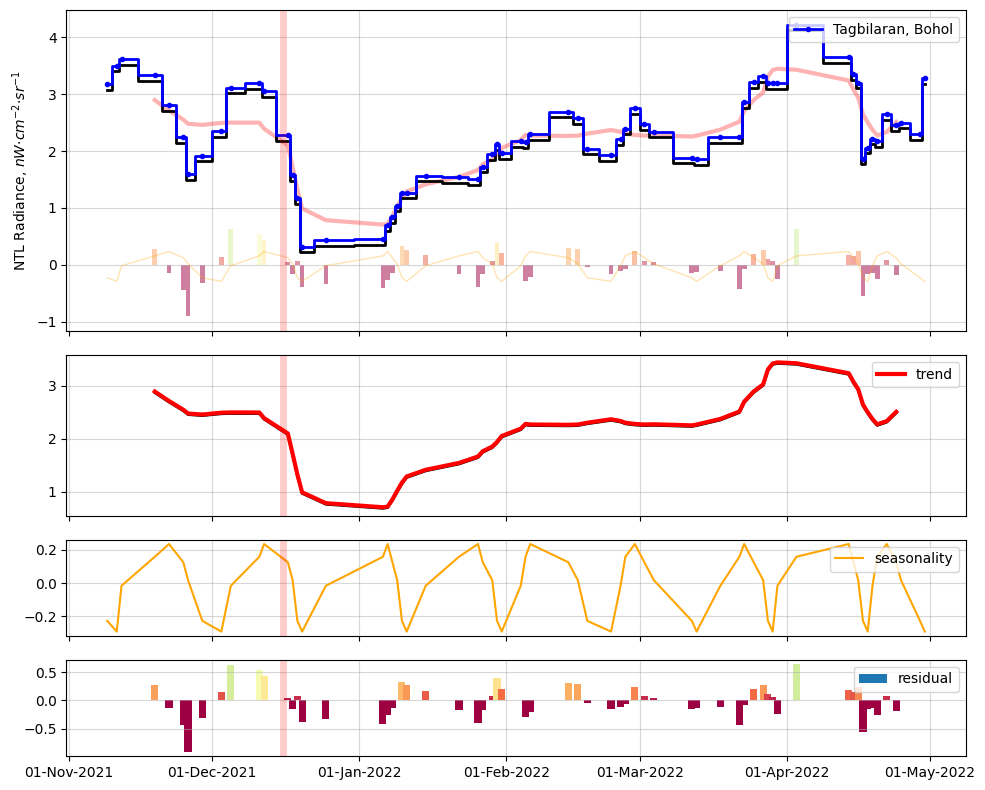

In [48]:
Black_Marble_STL(lat-delta, lon+delta, loc, 5000, "2021-11-01", "2022-5-01", period = 7)

In [58]:
loc = 'Bacolod City'
lat, lon = get_coords(loc)
delta = 0
map_viewer(lat-delta, lon+delta, loc, 10000, "2021-12-01", "2022-02-28", zoom = 11)

Map(center=[10.647145038873056, 122.99285917947613], controls=(WidgetControl(options=['position', 'transparent…

In [64]:
loc = 'Panay Gulf'
lat, loc = 10.167434714246246, 121.13910870371484
delta = 0
map_viewer(lat-delta, lon+delta, loc, 10000, "2021-12-01", "2022-02-28", zoom = 11)

Map(center=[10.16744497311951, 122.99285917903043], controls=(WidgetControl(options=['position', 'transparent_…

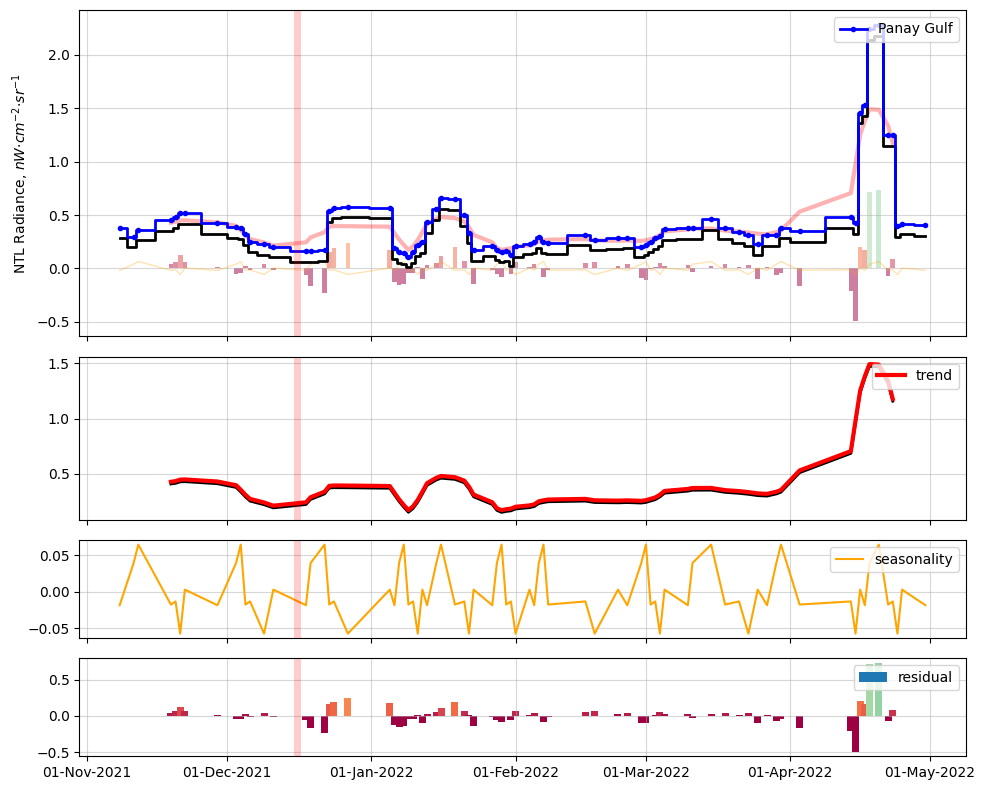

In [60]:
lat, loc = 10.157998999275481, 122.37927085681284
Black_Marble_STL(lat-delta, lon+delta, "Panay Gulf", 5000, "2021-11-01", "2022-5-01", period = 7)

# Black Marble - Regional

In [ ]:
select_regions_names = ['NCR',
                'CAR',
                'Region I',
                'Region II',
                'Region III',
                'Region IV-A',
                'Region IV-B',
                'Region V',
                'Region VI',
                'Region VII',
                'Region VIII',
                'Region IX',
                'Region X',
                'Region XI',
                'Region XII',
                'Region XIII',
                'ARMM']
select_regions = [2355, 2354, 2356, 2357,
           67165, 67166, 67167,
           2361, 2362, 2363, 2364,
           67159, 67160, 67161, 67162,
           2368, 67156]

In [ ]:
start_date = "2020-01-01"
end_date = "2020-12-31"
black_marble = ee.ImageCollection('NOAA/VIIRS/001/VNP46A2').filterDate(start_date, end_date).select('DNB_BRDF_Corrected_NTL')
reg_geoms = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.inList('ADM1_CODE', select_regions))


In [ ]:
# function to reduce our collection of geometries'
def get_reg_avg_rad(img):
    return img.reduceRegions(reducer=ee.Reducer.mean(), collection=reg_geoms, scale=500)

# function to get individual image dates
def get_date(img):
    return img.set('date', img.date().format())

# map these functions to our image collection
reduced_regions = black_marble.map(get_reg_avg_rad).flatten()
dates = black_marble.map(get_date)


# get lists
key_cols = ['ADM1_CODE','mean']

regions_list = reduced_regions.reduceColumns(ee.Reducer.toList(len(key_cols)), key_cols).values()
dates_list = dates.reduceColumns(ee.Reducer.toList(1), ['date']).values()

# some numpy maneuvers to structure our data
df = pd.DataFrame(np.asarray(regions_list.getInfo()).squeeze(), columns=key_cols)
dates = np.asarray(dates_list.getInfo()).squeeze()

In [ ]:
df

,ADM1_CODE,mean
0,2368.0,0.246291
1,67156.0,0.219569
2,67159.0,0.185942
3,67160.0,0.442486
4,67161.0,0.723893
...,...,...
5214,2357.0,8.223082
5215,2361.0,5.802581
5216,2362.0,5.712418
5217,2363.0,0.736249


In [ ]:
regions

2355

In [ ]:
df['ADM1_CODE']==regions

ValueError: ignored

In [ ]:
dates[:len(df.loc[df['ADM1_CODE']==regions,'dates'])]

KeyError: ignored

In [ ]:
for regions in select_regions:
  df.loc[df['ADM1_CODE']==regions,'dates'] = dates[:len(df.loc[df['ADM1_CODE']==regions,'dates'])]

# as we've done before, convert date and set index
# df['dates'] = pd.to_datetime(df['dates'])
# df.set_index('dates', inplace=True)

# # we'll also convert our mean datatype to float
# df['mean'] = df['mean'].astype(float)
# df

KeyError: ignored

In [ ]:
  nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date', 'mean']).values().get(0)
      data = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])
      data['date'] = pd.to_datetime(data['date'])
      data = data.set_index('date')